# Global mean sea level variation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels as sm
from datetime import timedelta, datetime

C:\Users\ACER\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The dataset contains Global Mean Sea Level (GMSL) variations compared to the 20 year collinear mean reference from year 1996 - 2016, from [NASA](https://sealevel.nasa.gov/understanding-sea-level/key-indicators/global-mean-sea-level/) (download [here](https://podaac-tools.jpl.nasa.gov/drive/files/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_4.2_199209_202004.txt))

In [2]:
raw_data = pd.read_csv('HDR Global Mean Sea Level Data.txt', sep = "\n", skiprows = 49)
raw_data.head()

,HDR Header_End---------------------------------------
0,0 11 1993.0115260 466462 337277.00 ...
1,0 12 1993.0386920 460889 334037.31 ...
2,0 13 1993.0658580 472123 342416.09 ...
3,0 14 1993.0930250 421377 306050.59 ...
4,0 15 1993.1201910 459548 331094.09 ...


In [3]:
header_names = ['Type', 'Cycle', 'Year', 'nOfObs', 'nOfWObs', 'GMSL1', 'stdGMSL1', 'smGMSL1',
                'GMSL2', 'stdGMSL2', 'smGMSL2', 'smGMSL3']
raw_data.columns = ['Lines']
df = raw_data['Lines'].str.split(n = 12, expand=True)
df.columns = header_names
df = df.astype(float)
df = df.astype({'nOfObs': int})
df.head()

,Type,Cycle,Year,nOfObs,nOfWObs,GMSL1,stdGMSL1,smGMSL1,GMSL2,stdGMSL2,smGMSL2,smGMSL3
0,0.0,11.0,1993.011526,466462,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44


## 1. Visualization
The dataset represents GMSL variation in several conditions (column description in the data file).   
Let's plot a time series of 2 columns GMSL2 and smGMSL3 in time series format.  
GMSL2 is GMSL with Global Isostatic Adjustment (GIA) applied, while smGMSL3 is a smoothed GMSL2 with annual and semi-annual signals removed

In [4]:
df1 = df[['Year','GMSL2','smGMSL3']]
df1 = df1.set_index('Year')
df1

,GMSL2,smGMSL3
Year,,
1993.011526,-37.24,-37.55
1993.038692,-40.34,-38.06
1993.065858,-40.16,-37.60
1993.093025,-41.89,-37.45
1993.120191,-36.85,-36.44
...,...,...
2020.214983,53.36,56.46
2020.242075,54.59,56.61
2020.269167,55.20,56.83


In [5]:
#df1.plot(figsize = (15,12), linewidth = 1.5)
#plt.xlabel('Time')
#plt.ylabel('GMSL variation (mm)')
#plt.title('GMSL Variation', fontsize = 30)
#plt.show()

In [6]:
import plotly.graph_objs as go
import plotly.express as ex
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [7]:
#df1.iplot(kind='line', xTitle='Time (years)', 
#          yTitle='GMSL (mm)', title='Global Mean Sea Level (mm)', width = 1.5)

In [8]:
fig = go.Figure( layout=go.Layout(
        xaxis=dict(title = "Year", color = 'black'),
        yaxis=dict(title = "GMSL variation (mm)", color = 'black'),
    ))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['GMSL2'],
                name="GMSL2",
                line_color= 'rgb(256, 150, 8)', line_width = 1.5,
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['smGMSL3'],
                name="smGMSL3",
                line_color='rgb(50, 100, 185)', line_width = 1.5,
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text = "Global mean sea level variation (mm)", title_x=0.5, title_font_size = 22,
                  paper_bgcolor = 'rgb(245, 246, 250)', plot_bgcolor = 'rgb(245, 246, 250)')
fig.show()

From the line graph, we can see that the global mean sea level generally increase from roughly -38mm in 1993 to 58mm in 2020. It is quite easy to understand if it continue to rise in the coming years, which would certainly impact countries in terms of land, population or GDP.

## 2. Prediction

In this section, we will try to predict the future trend of the variation. First, we will fit some simple model such as Linear Regression and Polynomial Regression

### a) Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
x = df1.index.values.reshape(-1, 1) 
y_GMSL2 = df1.iloc[:,0]
y_smGMSL3 = df1.iloc[:,1]
LR = LinearRegression()
LR.fit(x, y_GMSL2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# Generate new years
def generate_year(start_year, end_year):
    step = 0.01
    year_list = []
    while (start_year < end_year):
        start_year += step
        year_list.append(start_year)
    return year_list

In [11]:
x_futureyears = np.array(generate_year(x.flatten()[-1], 2030)).reshape(-1, 1)
pred = LR.predict(x_futureyears)
df3 = pd.DataFrame(data = x_futureyears, columns = ['Year'])
df3['GMSL2_pred'] = pred

### b) Polynomial linear regression

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
poly_features = PolynomialFeatures(degree = 5)
x_poly = poly_features.fit_transform(x)
x_futureyears_poly = poly_features.fit_transform(x_futureyears)
LR.fit(x_poly, y_GMSL2)
poly_pred = LR.predict(x_futureyears_poly)
df3['GMSL2_poly_pred'] = poly_pred

In [18]:
fig = go.Figure( layout=go.Layout(xaxis=dict(title = "Year", color = 'black'),
        yaxis=dict(title = "GMSL variation (mm)", color = 'black'),
    ))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['GMSL2'],
                name="GMSL2",
                line_color= 'rgb(256, 150, 8)', line_width = 1.5,
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['smGMSL3'],
                name="smGMSL3",
                line_color='rgb(50, 100, 185)', line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_pred']),
                name="GMSL_pred",
                line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_poly_pred']),
                name="GMSL_poly_pred",
                line_width = 1.5,
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text = "Global mean sea level variation (mm)", title_x=0.5, title_font_size = 22,
                  paper_bgcolor = 'rgb(245, 246, 250)', plot_bgcolor = 'rgb(245, 246, 250)')
fig.show()

### c) Prophet

In [14]:
def is_leap(year):
    return year % 4 == 0 and year % 100 != 0 and year % 400 == 0
def convert_partial_year(number):
    year = int(number)
    d = timedelta(days=(number - year)*(365 + is_leap(year)))
    day_one = datetime(year,1,1)
    date = d + day_one
    return date

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\ACER\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



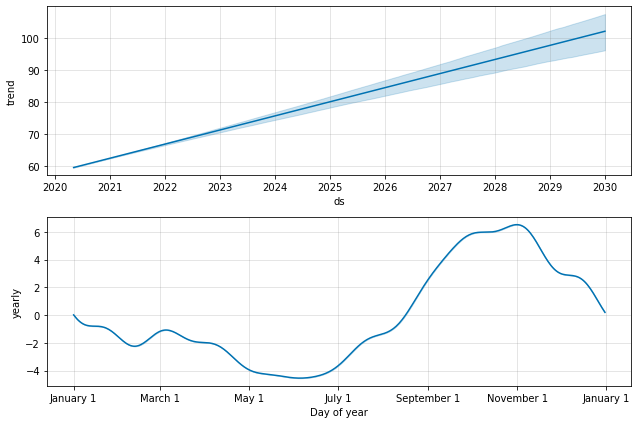

In [15]:
from fbprophet import Prophet
pp = Prophet()
df_prophet = pd.DataFrame()
df_prophet['ds'] = df1.index.values
df_prophet['ds'] = df_prophet['ds'].apply(convert_partial_year)
df_prophet['y'] = df1['GMSL2'].values
pp.fit(df_prophet)
future = pd.DataFrame(data = x_futureyears, columns = ['ds'])
future['ds'] = future['ds'].apply(convert_partial_year)
GMSL2_pp_pred = pp.predict(future)
#pp.plot(GMSL2_pp_pred)
pp.plot_components(GMSL2_pp_pred)
df3['GMSL2_pp_pred'] = GMSL2_pp_pred['yhat'].values

In [16]:
fig = go.Figure( layout=go.Layout(xaxis=dict(title = "Year", color = 'black'),
        yaxis=dict(title = "GMSL variation (mm)", color = 'black'),
    ))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['GMSL2'],
                name="GMSL2",
                line_color= 'rgb(256, 150, 8)', line_width = 1.5,
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['smGMSL3'],
                name="smGMSL3",
                line_color='rgb(50, 100, 185)', line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_pred']),
                name="GMSL_pred",
                line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_poly_pred']),
                name="GMSL_poly_pred",
                line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_pp_pred']),
                name="GMSL_pp_pred",
                line_width = 1.5,
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text = "Global mean sea level variation (mm)", title_x=0.5, title_font_size = 22,
                  paper_bgcolor = 'rgb(245, 246, 250)', plot_bgcolor = 'rgb(245, 246, 250)')
fig.show()

Sea level rise is caused primarily by two factors related to global warming: the added water from melting ice sheets and glaciers and the expansion of seawater as it warms